In [1]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from xgboost import XGBClassifier


In [2]:

# Load training and testing datasets from CSV
train_df = pd.read_csv("sensor_data_train.csv")
test_df = pd.read_csv("sensor_data_test.csv")

# Convert Timestamp back to datetime (good practice)
train_df["Timestamp"] = pd.to_datetime(train_df["Timestamp"])
test_df["Timestamp"] = pd.to_datetime(test_df["Timestamp"])

# Split features and target
X_train = train_df.drop(columns=["Leak", "Timestamp"])
y_train = train_df["Leak"]

X_test = test_df.drop(columns=["Leak", "Timestamp"])
y_test = test_df["Leak"]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2000, 8) (2000,)
Test shape: (2000, 8) (2000,)


In [3]:
# model 1 (default threshold)
baseline_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)

baseline_model.fit(X_train, y_train)

# Predictions
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]
y_pred_base = baseline_model.predict(X_test)

print("\nBASELINE MODEL REPORT")
print(classification_report(y_test, y_pred_base, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_base))



BASELINE MODEL REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       0.75      1.00      0.86         3

    accuracy                           1.00      2000
   macro avg       0.88      1.00      0.93      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 1.0


In [4]:
# improved model (probability threshold + alert system)
# Custom threshold for rare-event detection
THRESHOLD = 0.3
y_pred_improved = (y_prob_base > THRESHOLD).astype(int)

print("\nIMPROVED MODEL REPORT (Threshold = 0.3)")
print(classification_report(y_test, y_pred_improved, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_base))



IMPROVED MODEL REPORT (Threshold = 0.3)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       0.60      1.00      0.75         3

    accuracy                           1.00      2000
   macro avg       0.80      1.00      0.87      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 1.0


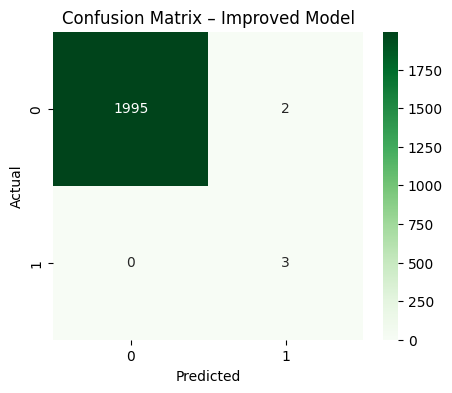

In [5]:
# confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_improved)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix – Improved Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


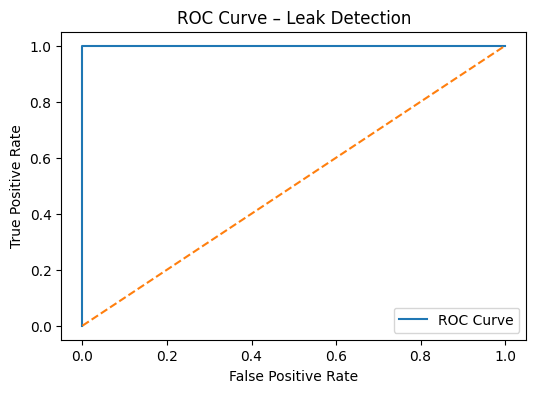

In [6]:
# roc curve
fpr, tpr, _ = roc_curve(y_test, y_prob_base)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Leak Detection")
plt.legend()
plt.show()


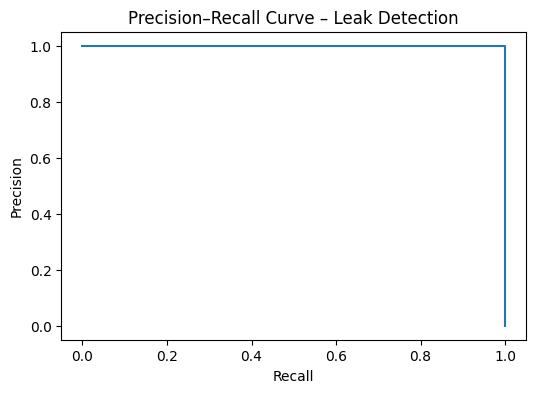

In [ ]:
# precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_base)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Leak Detection")
plt.show()


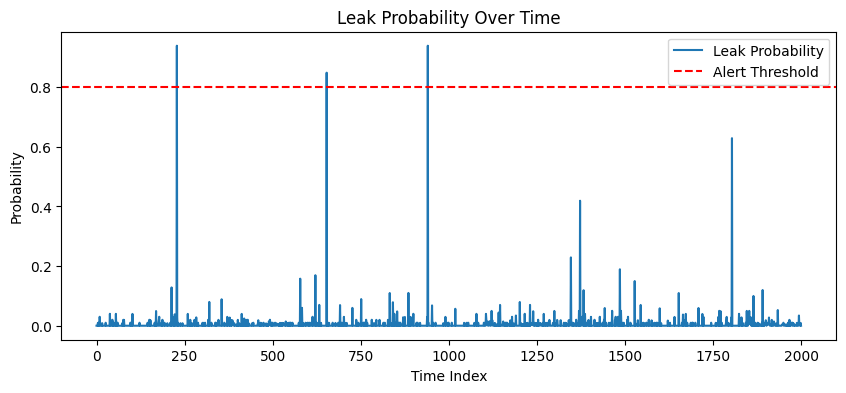

In [8]:
# leak probability over time
plt.figure(figsize=(10,4))
plt.plot(y_prob_base, label="Leak Probability")
plt.axhline(0.8, color="red", linestyle="--", label="Alert Threshold")
plt.xlabel("Time Index")
plt.ylabel("Probability")
plt.title("Leak Probability Over Time")
plt.legend()
plt.show()



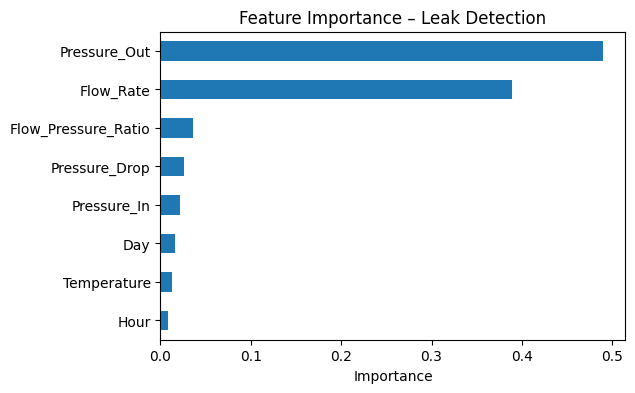

In [9]:
# feature importance
importances = baseline_model.feature_importances_
features = X_train.columns

pd.Series(importances, index=features).sort_values().plot(
    kind="barh", figsize=(6,4)
)

plt.title("Feature Importance – Leak Detection")
plt.xlabel("Importance")
plt.show()


In [10]:
# alert system simulation
alert_counter = 0

for prob in y_prob_base:
    if prob > 0.8:
        alert_counter += 1
    else:
        alert_counter = 0

    if alert_counter >= 3:
        print(" ALERT: Potential leak detected!")
        break


In [11]:
# implementing xgboost model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

print("XGBoost model training completed")

XGBoost model training completed


In [12]:
# baseline predictions (with XGBoost)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import classification_report, roc_auc_score

print("XGBOOST BASELINE RESULTS")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


XGBOOST BASELINE RESULTS
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       0.60      1.00      0.75         3

    accuracy                           1.00      2000
   macro avg       0.80      1.00      0.87      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 1.0


In [13]:
# improved model (custom threshold)(with XGBoost)
THRESHOLD = 0.3
y_pred_xgb_improved = (y_prob_xgb > THRESHOLD).astype(int)

print("\nXGBOOST IMPROVED RESULTS (Threshold = 0.3)")
print(classification_report(y_test, y_pred_xgb_improved, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))



XGBOOST IMPROVED RESULTS (Threshold = 0.3)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       0.50      1.00      0.67         3

    accuracy                           1.00      2000
   macro avg       0.75      1.00      0.83      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 1.0


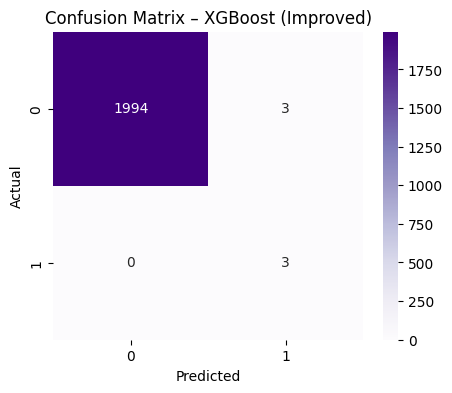

In [14]:
# confusion matrix visualization (with XGBoost)

cm_xgb = confusion_matrix(y_test, y_pred_xgb_improved)

plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix – XGBoost (Improved)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


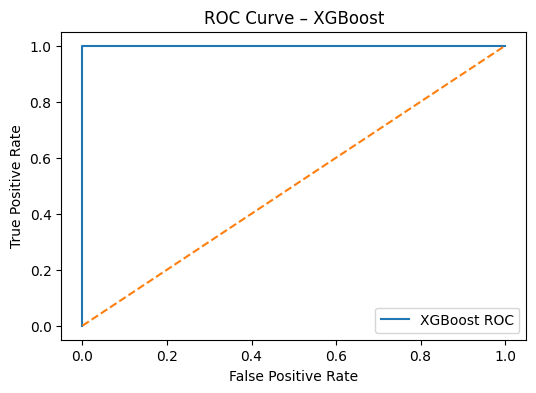

In [15]:
# roc curve(xg boost)


fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(6,4))
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost ROC")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost")
plt.legend()
plt.show()


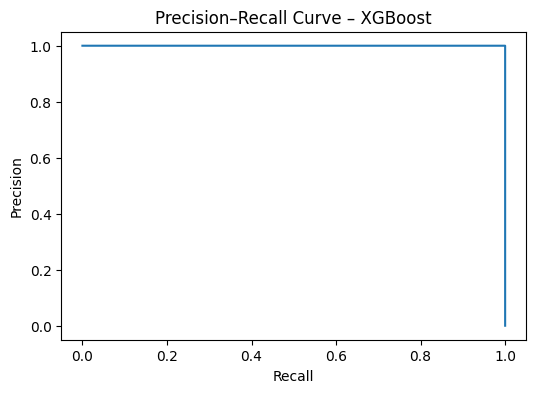

In [16]:
# precision-recall curve (xgboost)

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

plt.figure(figsize=(6,4))
plt.plot(recall_xgb, precision_xgb)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – XGBoost")
plt.show()


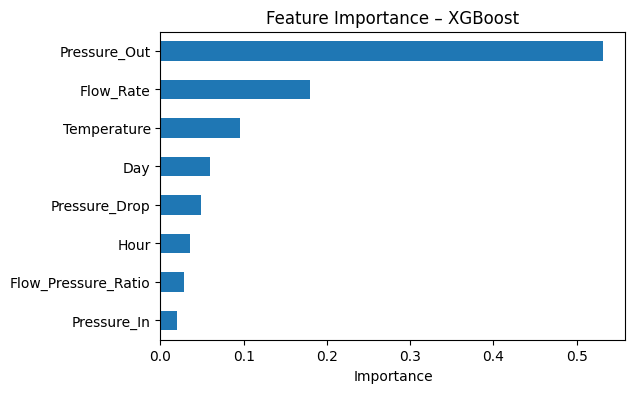

In [17]:
# feature importance (xgboost)
xgb_importance = xgb_model.feature_importances_

import pandas as pd
pd.Series(xgb_importance, index=X_train.columns).sort_values().plot(
    kind="barh", figsize=(6,4)
)

plt.title("Feature Importance – XGBoost")
plt.xlabel("Importance")
plt.show()
